# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [30]:
# Imports
import tensorflow as tf
import tensorflow.contrib.slim as slim  # TensorFlow-Slim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.cross_validation import train_test_split
import numpy as np
import cv2
import math
import os
import time
import pickle
%matplotlib inline

# Settings/parameters to be used later

# Constants
IMG_SIZE = 32  # square image of size IMG_SIZE x IMG_SIZE
GRAYSCALE = False  # convert image to grayscale?
NUM_CHANNELS = 1 if GRAYSCALE else 3
NUM_CLASSES = 43

# Model parameters
LR = 5e-3  # learning rate
KEEP_PROB = 0.5  # dropout keep probability
OPT = tf.train.GradientDescentOptimizer(learning_rate=LR)  # choose which optimizer to use

# Training process
RESTORE = False  # restore previous model, don't train?
RESUME = False  # resume training from previously trained model?
NUM_EPOCH = 40
BATCH_SIZE = 128  # batch size for training (relatively small)
BATCH_SIZE_INF = 2048  # batch size for running inference, e.g. calculating accuracy
VALIDATION_SIZE = 0.2  # fraction of total training set to use as validation set
SAVE_MODEL = True  # save trained model to disk?
MODEL_SAVE_PATH = './model.ckpt'  # where to save trained model

########################################################
# Helper functions and generators
########################################################
def rgb_to_gray(images):
    """
    Convert batch of RGB images to grayscale
    Use simple average of R, G, B values, not weighted average

    Arguments:
        * Batch of RGB images, tensor of shape (batch_size, 32, 32, 3)

    Returns:
        * Batch of grayscale images, tensor of shape (batch_size, 32, 32, 1)
    """
    images_gray = np.average(images, axis=3)
    images_gray = np.expand_dims(images_gray, axis=3)
    return images_gray


def preprocess_data(X, y):
    """
    Preprocess image data, and convert labels into one-hot

    Arguments:
        * X: Image data
        * y: Labels

    Returns:
        * Preprocessed X, one-hot version of y
    """
    # Convert from RGB to grayscale if applicable
    if GRAYSCALE:
        X = rgb_to_gray(X)

    # Make all image array values fall within the range -1 to 1
    # Note all values in original images are between 0 and 255, as uint8
    X = X.astype('float32')
    X = (X - 128.) / 128.

    # Convert the labels from numerical labels to one-hot encoded labels
    y_onehot = np.zeros((y.shape[0], NUM_CLASSES))
    for i, onehot_label in enumerate(y_onehot):
        onehot_label[y[i]] = 1.
    y = y_onehot

    return X, y


def next_batch(X, y, batch_size, augment_data):
    """
    Generator to generate data and labels
    Each batch yielded is unique, until all data is exhausted
    If all data is exhausted, the next call to this generator will throw a StopIteration

    Arguments:
        * X: image data, a tensor of shape (dataset_size, 32, 32, 3)
        * y: labels, a tensor of shape (dataset_size,)  <-- i.e. a list
        * batch_size: Size of the batch to yield
        * augment_data: Boolean value, whether to augment the data (i.e. perform image transform)

    Yields:
        A tuple of (images, labels), where:
            * images is a tensor of shape (batch_size, 32, 32, 3)
            * labels is a tensor of shape (batch_size,)
    """
    # A generator in this case is likely overkill,
    # but using a generator is a more scalable practice,
    # since future datasets may be too large to fit in memory

    # We know X and y are randomized from the train/validation split already,
    # so just sequentially yield the batches
    start_idx = 0
    while start_idx < X.shape[0]:
        images = X[start_idx : start_idx + batch_size]
        labels = y[start_idx : start_idx + batch_size]

        yield (np.array(images), np.array(labels))

        start_idx += batch_size


def calculate_accuracy(data_gen, data_size, batch_size, accuracy, x, y, keep_prob, sess):
    """
    Helper function to calculate accuracy on a particular dataset

    Arguments:
        * data_gen: Generator to generate batches of data
        * data_size: Total size of the data set, must be consistent with generator
        * batch_size: Batch size, must be consistent with generator
        * accuracy, x, y, keep_prob: Tensor objects in the neural network
        * sess: TensorFlow session object containing the neural network graph

    Returns:
        * Float representing accuracy on the data set
    """
    num_batches = math.ceil(data_size / batch_size)
    last_batch_size = data_size % batch_size

    accs = []  # accuracy for each batch

    for _ in range(num_batches):
        images, labels = next(data_gen)

        # Perform forward pass and calculate accuracy
        # Note we set keep_prob to 1.0, since we are performing inference
        acc = sess.run(accuracy, feed_dict={x: images, y: labels, keep_prob: 1.})
        accs.append(acc)

    # Calculate average accuracy of all full batches (the last batch is the only partial batch)
    acc_full = np.mean(accs[:-1])

    # Calculate weighted average of accuracy accross batches
    acc = (acc_full * (data_size - last_batch_size) + accs[-1] * last_batch_size) / data_size

    return acc

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = (39209,)


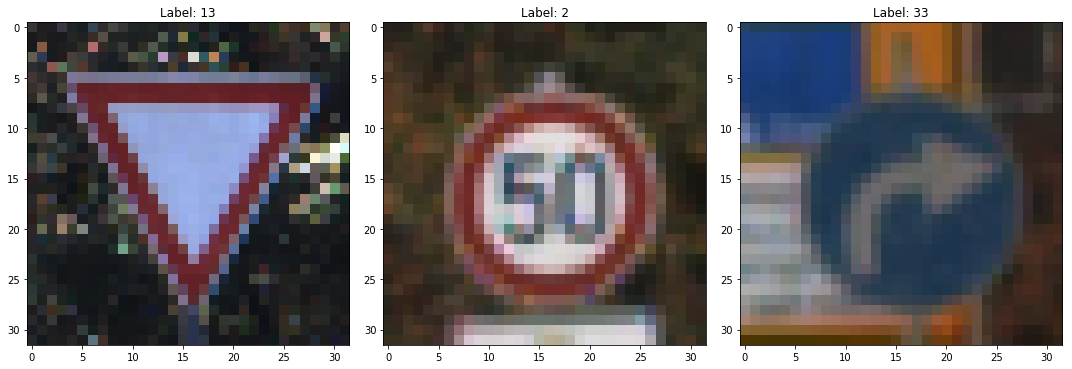

In [31]:
# Load pickled data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

### To start off let's do a basic data summary.

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# What's the shape of an image?
image_shape = X_train.shape[0:]

# How many classes are in the dataset
n_classes = y_train.shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# Randomly choose indices to represent which datapoints we choose from the training set
num_images = 3
indices = np.random.choice(list(range(n_train)), size=num_images, replace=False)

# Obtain the images and labels
images = X_train[indices]
labels = y_train[indices]

# Display the images
plt.rcParams["figure.figsize"] = [15, 5]

for i, image in enumerate(images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(image)
    plt.title('Label: %d' % labels[i])
    
plt.tight_layout()
plt.show()

#### Randomly choose 3 images from training set and display them, along with their labels

#### Display histogram to show class/label distribution across training data

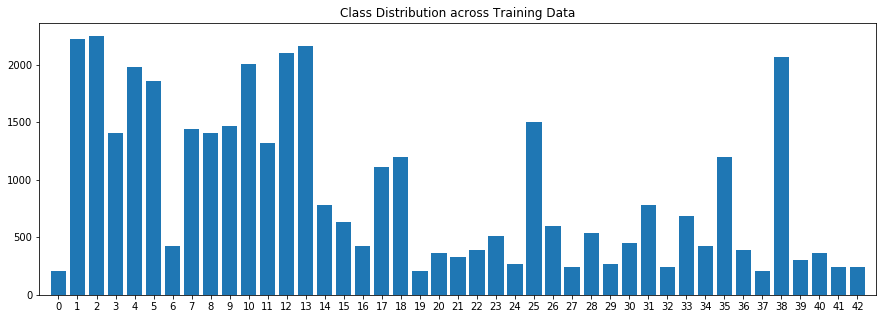

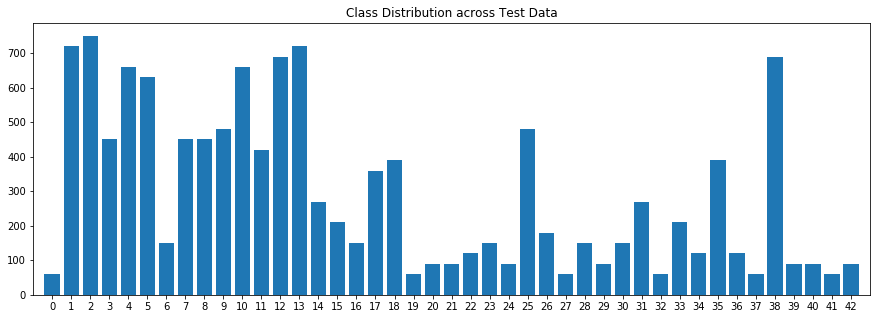

In [32]:
# Count frequency of each label
labels, counts = np.unique(y_train, return_counts=True)

# Plot the histogram
plt.rcParams["figure.figsize"] = [15, 5]
axes = plt.gca()
axes.set_xlim([-1,43])

plt.bar(labels, counts, tick_label=labels, width=0.8, align='center')
plt.title('Class Distribution across Training Data')
plt.show()

# Count frequency of each label
labels, counts = np.unique(y_test, return_counts=True)

# Plot the histogram
plt.rcParams["figure.figsize"] = [15, 5]
axes = plt.gca()
axes.set_xlim([-1,43])

plt.bar(labels, counts, tick_label=labels, width=0.8, align='center')
plt.title('Class Distribution across Test Data')
plt.show()

As shown above, the training data's class distribution is highly skewed, so we must keep this in mind.

#### Display histogram to show class/label distribution across test data

We see the test data is *also* skewed, in the same way the training data is skewed. The only difference is the individual counts for each class are less, as expected.

If we wanted to maximize the accuracy on the *test set*, then it does not make sense to balance the class distribution on the training set, since the test set is skewed in the same way the training set is skewed.

Note that if our goal to to maximize a different metric, such as the F1 score, it may be more beneficial to balance the training set. Also, in practice, the traffic signs we see daily may not be unfiformly distributed, and different traffic signs may have more or less importance relative to other signs. So it is a non-trivial judgement of which metric is the best: accuracy, F1 score, or a different metric.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Image data augmentation

From our data exploration above, we only have 39,209 samples in our training set. After performing a standard 80/20 train/validation split, we would be left with too little training samples. Thus, it is beneficial to artificially increase the size of the training set, by generating new images using the existing images in the training set. This process is known as "data augmentation".

The training data was augmented by running `python data_aug.py`. The training data augmentation process is as follows:
```
Deep copy original training dataset to augmented dataset
Repeat 100,000 times:
    Choose random image from original training set
    Perform random rotation and translation on that image
    Add transformed image to augmented dataset
    Add appropriate label to augmented dataset
Save augmented dataset to disk at train_aug.p
```
This will add 100,000 randomly transformed images to our original training set. The data augmentation process was run only once (it took a few hours to run on my machine), and the augmented training data was saved in `train_aug.p`. The code for data augmentation can be found in `data_aug.py`.

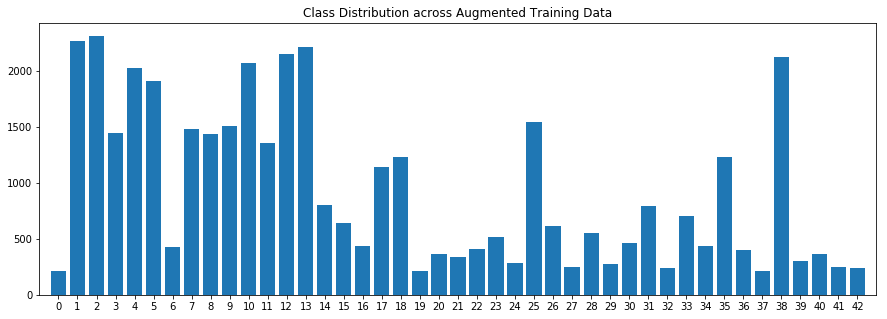

In [33]:
# Load augmented training dataset
with open('train_aug.p', mode='rb') as f:
    train = pickle.load(f)
X_train, y_train = train['features'], train['labels']

# Count frequency of each label
labels, counts = np.unique(y_train, return_counts=True)

# Plot the histogram
plt.rcParams["figure.figsize"] = [15, 5]
axes = plt.gca()
axes.set_xlim([-1,43])

plt.bar(labels, counts, tick_label=labels, width=0.8, align='center')
plt.title('Class Distribution across Augmented Training Data')
plt.show()

#### Check the class distribution of the augmented training dataset, the distribution should be similar to that of the original training dataset.

As seen above, the class distribution of the augmented training dataset is similar to that of the original training dataset. Now, let's visually inspect a few random images from the augmented dataset.

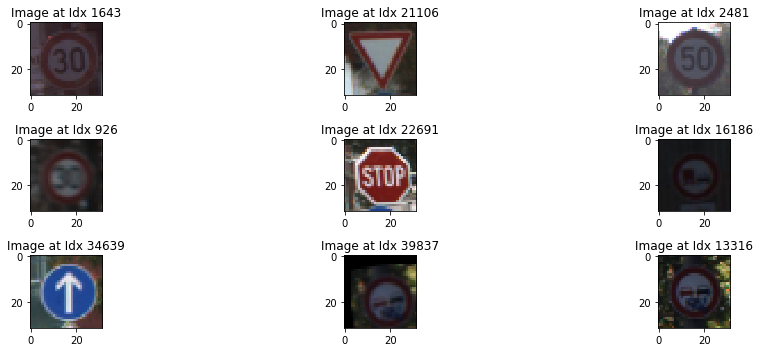

In [34]:
# Choose random training image and visually inspect transformed images
random_idx = np.random.randint(0, n_train)
image = X_train[random_idx]

for i in range(9):
    rand_idx = np.random.randint(X_train.shape[0])
    image = X_train[rand_idx]
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title('Image at Idx %d' % (rand_idx,))

plt.tight_layout()
plt.show()

The transformed images look fine, by visual inspection.

#### Further pre-processing image data

In [35]:
'''
preprocess_data() does the following:
* Mean normalizes the pixel values of the images
* Converts the labels to one-hot encoding
'''
X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)


#Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
I performed the following data preprocessing steps:
* Augmented the training dataset, by adding 100,000 transformed images to the original training set
  * Details and justification of dataset augmentation were described above
* Standardize the pixel values: `new_value = (old_value - 128) / 128`
  * This has the effect of zero-centering the data, and making the data fall within the range -1 to 1
  * Standardizing the pixel values helps gradient descent converge faster
  * Justification for zero-centering the data can be found at: https://youtu.be/GUtlrDbHhJM?t=19m
  * Dividing the pixel values by 128 is not strictly necessary for this project, because all original pixel values are on the same scale, from 0 to 255. However, this division step is computationally cheap, and it's good practice in the long term to standardize the image preprocessing requirements, over many different projects with potentially different image representations. Over the course of many projects in the future, abiding by this practice can help reduce confusion and potential frustration.
* Convert the integer class labels into one-hot encoded labels
  * This is important because different traffic signs do not have integer-like relationships with one another. For example, if a stop sign is labeled 0, a speed limit sign labeled 1, and a yield sign labeled 2, an integer label would imply a stop sign is more similar to a speed limit sign than a yield sign. A neural network classifier would mathematically assume this relationship as well. Practically, there is no such relationship. By converting all labels into one-hot encoded labels, we avoid this incorrect underlying assumption.

Note I did *not* do grayscaling, because I found it did not improve accuracy, and it adds extra time to the inference process.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

As described above, I generated additional training data by augmenting the training dataset. The justification for generating additional data is because the original training set is too small -- more details were described above.

The German Traffic Sign Dataset includes a pre-made test set, so I simply used the provided test set as-is.

I created my own train/validation dataset split. I used Scikit-learn's `train_test_split()` function to perform a random train/validation split on my augmented training dataset, with 80% of the dataset allocated to training, 20% allocated to validation.

However, one important thing to note is that the validation set is unfortunately correlated with the training set. This is because the entire original training set was augmented, before the train/validation split was done. Thus, there are highly correlated images between the training and validation sets. For example, I may have an image of a stop sign in the training set, but also have an image of the same stop sign slightly rotated, in the validation set.

One way to mitigate the above issue is to perform the train/validation split _before_ training set augmentation. However, due to the relatively small size of the training set, I did not choose this option. If the training set were larger (e.g. 100,000+ samples), I may decide to go this route.

### Define neural network architecture

In [14]:
def neural_network():
    """
    Define neural network architecture
    Return relevant tensor references
    """
    with tf.variable_scope('neural_network'):
        # Tensors representing input images and labels
        x = tf.placeholder('float', [None, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
        y = tf.placeholder('float', [None, NUM_CLASSES])

        # Placeholder for dropout keep probability
        keep_prob = tf.placeholder(tf.float32)

        # Neural network architecture: Convolutional Neural Network (CNN)
        # Using TensorFlow-Slim to build the network:
        # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim

        # Use batch normalization for all convolution layers
        with slim.arg_scope([slim.conv2d], normalizer_fn=slim.batch_norm):
            # Given x shape is (32, 32, 3)
            # Conv and pool layers
            net = slim.conv2d(x, 16, [3, 3], scope='conv0')  # output shape: (32, 32, 16)
            net = slim.max_pool2d(net, [3, 3], 1, padding='SAME', scope='pool0')  # output shape: (32, 32, 16)
            net = slim.conv2d(net, 64, [5, 5], 3, padding='VALID', scope='conv1')  # output shape: (10, 10, 64)
            net = slim.max_pool2d(net, [3, 3], 1, scope='pool1')  # output shape: (8, 8, 64)
            net = slim.conv2d(net, 128, [3, 3], scope='conv2')  # output shape: (8, 8, 128)
            net = slim.conv2d(net, 64, [3, 3], scope='conv3')  # output shape: (8, 8, 64)
            net = slim.max_pool2d(net, [3, 3], 1, scope='pool3')  # output shape: (6, 6, 64)

            # Final fully-connected layers
            net = tf.contrib.layers.flatten(net)
            net = slim.fully_connected(net, 1024, scope='fc4')
            net = tf.nn.dropout(net, keep_prob)
            net = slim.fully_connected(net, 1024, scope='fc5')
            net = tf.nn.dropout(net, keep_prob)
            net = slim.fully_connected(net, NUM_CLASSES, scope='fc6')

        # Final output (logits)
        logits = net

        # Loss (data loss and regularization loss) and optimizer
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y))
        optimizer = OPT.minimize(loss)
        
        # Prediction (used during inference)
        predictions = tf.argmax(logits, 1)

        # Accuracy metric calculation
        correct_prediction = tf.equal(predictions, tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Return relevant tensor references
    return x, y, keep_prob, logits, optimizer, predictions, accuracy

In [36]:
"""
Define neural network architecture
Return relevant tensor references
"""

# Tensors representing input images and labels
x = tf.placeholder('float', [None, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
y = tf.placeholder('float', [None, NUM_CLASSES])

# Placeholder for dropout keep probability
keep_prob = tf.placeholder(tf.float32)

# Neural network architecture: Convolutional Neural Network (CNN)
# Using TensorFlow-Slim to build the network:
# https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim

# Use batch normalization for all convolution layers
with slim.arg_scope([slim.conv2d], normalizer_fn=slim.batch_norm):
    # Given x shape is (32, 32, 3)
    # Conv and pool layers
    net = slim.conv2d(x, 16, [3, 3], scope='conv0')  # output shape: (32, 32, 16)
    net = slim.max_pool2d(net, [3, 3], 1, padding='SAME', scope='pool0')  # output shape: (32, 32, 16)
    net = slim.conv2d(net, 64, [5, 5], 3, padding='VALID', scope='conv1')  # output shape: (10, 10, 64)
    net = slim.max_pool2d(net, [3, 3], 1, scope='pool1')  # output shape: (8, 8, 64)
    net = slim.conv2d(net, 128, [3, 3], scope='conv2')  # output shape: (8, 8, 128)
    net = slim.conv2d(net, 64, [3, 3], scope='conv3')  # output shape: (8, 8, 64)
    net = slim.max_pool2d(net, [3, 3], 1, scope='pool3')  # output shape: (6, 6, 64)

    # Final fully-connected layers
    net = tf.contrib.layers.flatten(net)
    net = slim.fully_connected(net, 1024, scope='fc4')
    net = tf.nn.dropout(net, keep_prob)
    net = slim.fully_connected(net, 1024, scope='fc5')
    net = tf.nn.dropout(net, keep_prob)
    net = slim.fully_connected(net, NUM_CLASSES, scope='fc6')

# Final output (logits)
logits = net

# Loss (data loss and regularization loss) and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y))
optimizer = OPT.minimize(loss)

# Prediction (used during inference)
predictions = tf.argmax(logits, 1)

# Accuracy metric calculation
correct_prediction = tf.equal(predictions, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#     # Return relevant tensor references
#     return x, y, keep_prob, logits, optimizer, predictions, accuracy

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The overall architecture of my model is a convolutional neural network. I followed a similar structure as AlexNet (https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/alexnet.py), with the following differences:
* The overall dimensions of each layer are smaller, because our input image dimensions are smaller than that of the ImageNet challenge, and because we are trying to identify less classes
* I did _not_ downsample in the first convolutional layer like AlexNet did, because our input image dimensions are so small
* I have one less convolution layer after the 2nd pooling layer

In summary, my neural network architecture consists of the following 10 layers (not counting dropout), in order from input to output:
* Convolution with 3x3 kernel, stride of 1, depth of 16, same padding
* Max pooling with 3x3 kernel, stride of 1, same padding
* Convolution with 5x5 kernel, stride of 3, depth of 64, valid padding
* Max pooling with 3x3 kernel, stride of 1, valid padding
* Convolution with 3x3 kernel, stride of 1, depth of 128, same padding
* Convolution with 3x3 kernel, stride of 1, depth of 64, same padding
* Max pooling with 3x3 kernel, stride of 1, valid padding
* Fully-connected with 1024 hidden units
* Dropout
* Fully-connected with 1024 hidden units
* Dropout
* Fully-connected with 43 units, calculating the final 43 logits corresponding to target classes

For regularization, I used dropout on the final fully-connected layers.

Batch normalization was applied after the convolutional layers, to (a) make the model more robust to bad random weight initialization, (b) allow higher learning rates, and (c) help with regularization. More details about batch normalization are availabe at https://arxiv.org/abs/1502.03167 and http://cs231n.github.io/neural-networks-2/#batchnorm

Below is a visualization of my convolutional neural network's architecture, visualized using TensorBoard:
![title](graph.png)

### Train the neural network

In [37]:
# # Launch the graph
# with tf.Graph().as_default(), tf.Session() as sess:

sess = tf.Session()

# TF saver to save/restore trained model
saver = tf.train.Saver()

# This dumps summaries for TensorBoard
# Only dumping the graph, to visualize the architecture
train_writer = tf.summary.FileWriter('tf_summary/train', sess.graph)

def train_network():
        ########################################################
        # "Instantiate" neural network, get relevant tensors
        ########################################################
#         x, y, keep_prob, logits, optimizer, predictions, accuracy = neural_network()

        ########################################################
        # Training process
        ########################################################

        if RESUME or RESTORE:
            print('Restoring previously trained model at %s' % MODEL_SAVE_PATH)
            # Restore previously trained model
            saver.restore(sess, MODEL_SAVE_PATH)

            # Restore previous accuracy history
            with open('accuracy_history.p', 'rb') as f:
                accuracy_history = pickle.load(f)

            if RESTORE:
                return accuracy_history
        else:
            print('Training model from scratch')
            # Variable initialization
            init = tf.initialize_all_variables()
            sess.run(init)

            # For book-keeping, keep track of training and validation accuracy over epochs, like such:
            # [(train_acc_epoch1, valid_acc_epoch1), (train_acc_epoch2, valid_acc_epoch2), ...]
            accuracy_history = []

        # Record time elapsed for performance check
        last_time = time.time()
        train_start_time = time.time()

        # Run NUM_EPOCH epochs of training
        for epoch in range(NUM_EPOCH):
            # Instantiate generator for training data
            train_gen = next_batch(X_train, y_train, BATCH_SIZE, True)

            # How many batches to run per epoch
            num_batches_train = math.ceil(X_train.shape[0] / BATCH_SIZE)

            # Run training on each batch
            for _ in range(num_batches_train):
                # Obtain the training data and labels from generator
                images, labels = next(train_gen)

                # Perform gradient update (i.e. training step) on current batch
                sess.run(optimizer, feed_dict={x: images, y: labels, keep_prob: KEEP_PROB})

            # Calculate training and validation accuracy across the *entire* train/validation set
            # If train/validation size % batch size != 0
            # then we must calculate weighted average of the accuracy of the final (partial) batch,
            # w.r.t. the rest of the full batches

            # Training set
            train_gen = next_batch(X_train, y_train, BATCH_SIZE_INF, True)
            train_size = X_train.shape[0]
            train_acc = calculate_accuracy(train_gen, train_size, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)

            # Validation set
            valid_gen = next_batch(X_valid, y_valid, BATCH_SIZE_INF, True)
            valid_size = X_valid.shape[0]
            valid_acc = calculate_accuracy(valid_gen, valid_size, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)

            # Record and report train/validation/test accuracies for this epoch
            accuracy_history.append((train_acc, valid_acc))

            # Print accuracy every 10 epochs
            if (epoch+1) % 10 == 0 or epoch == 0 or (epoch+1) == NUM_EPOCH:
                print('Epoch %d -- Train acc.: %.4f, Validation acc.: %.4f, Elapsed time: %.2f sec' %\
                    (epoch+1, train_acc, valid_acc, time.time() - last_time))
                last_time = time.time()

        total_time = time.time() - train_start_time
        print('Total elapsed time: %.2f sec (%.2f min)' % (total_time, total_time/60))

        # After training is complete, evaluate accuracy on test set
        print('Calculating test accuracy...')
        test_gen = next_batch(X_test, y_test, BATCH_SIZE_INF, False)
        test_size = X_test.shape[0]
        test_acc = calculate_accuracy(test_gen, test_size, BATCH_SIZE_INF, accuracy, x, y, keep_prob, sess)
        print('Test acc.: %.4f' % (test_acc,))

        if SAVE_MODEL:
            # Also save accuracy history
            print('Accuracy history saved at accuracy_history.p')
            with open('accuracy_history.p', 'wb') as f:
                pickle.dump(accuracy_history, f)
                
        return accuracy_history


#### Plot the training and validation accuracies over epochs

In [39]:
accuracy_history = train_network()

Training model from scratch
Epoch 1 -- Train acc.: 0.4068, Validation acc.: 0.4140, Elapsed time: 3.59 sec
Epoch 10 -- Train acc.: 0.9673, Validation acc.: 0.9569, Elapsed time: 31.44 sec
Epoch 20 -- Train acc.: 0.9930, Validation acc.: 0.9868, Elapsed time: 35.13 sec
Epoch 30 -- Train acc.: 0.9975, Validation acc.: 0.9901, Elapsed time: 35.19 sec
Epoch 40 -- Train acc.: 0.9992, Validation acc.: 0.9924, Elapsed time: 35.32 sec
Total elapsed time: 140.68 sec (2.34 min)
Calculating test accuracy...
Test acc.: 0.9530
Accuracy history saved at accuracy_history.p


In [40]:
# Save model to disk
saver.save(sess, "./model.ckpt")

# Save model to disk
saver.restore(sess, "./model.ckpt")

INFO:tensorflow:Restoring parameters from ./model.ckpt


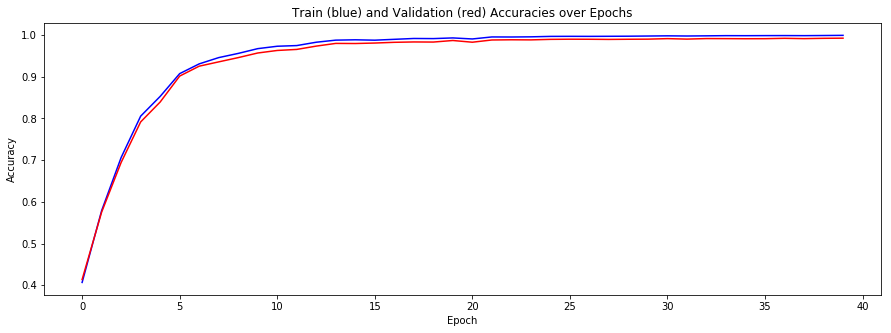

In [41]:
# Transpose accuracy_history
hist = np.transpose(np.array(accuracy_history))
plt.plot(hist[0], 'b')  # training accuracy
plt.plot(hist[1], 'r')  # validation accuracy
plt.title('Train (blue) and Validation (red) Accuracies over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

My model was trained via standard Stochastic Gradient Descent (SGD). I did not experiment with other optimizers yet, but that can be a future enhancement to this project.

When choosing a training batch size, I kept the following in mind:
* Batch size too small: Initial gradient updates will exhibit significant variance, causing slow convergence.
* Batch size too big: Either (a) my GPU will simply run out of memory, or (b) a single gradient update will take too long, to a point where it is not worth the extra variance reduction from going to a larger batch size (we are basically trying to "optimize" the gradient descent convergence speed).

Thus I chose a middle ground between the two extremes. I was not methodical in this process of batch size tuning, due to time constraints, and the return on investment of tuning the batch size did not seem high.

The number of epochs was chosen such that it is large enough to see the training and validation accuracies saturating. This means the model cannot improve anymore, given more training time.

The hyperparameters were chosen based on a random hyperparameter combination search. The code to perform the search is available in `search_params.py`. In this process, I randomly chose 20 hyperparameter combinations, ran training on my model, and chose the hyperparameter combination that gave the highest test accuracy. Realistically, I should have used the validation accuracy to determine which hyperparameter combination was the best, since the test set should be "hidden" until the model has been finalized.

Looking at the above plot of train vs. validation accuracy, we can see the validation accuracy is only slighly below the training accuracy throughout the training process, which is a good sign.

The model's accuracy on the official test set is 96.41%, which is a good score.

Below are my final settings and hyperparameters I used to train my model:
* Number of epochs: 40
* Batch size: 128
* Optimizer: Stochastic gradient descent (tf.train.GradientDescentOptimizer)
* Learning rate: 5e-3
* Dropout keep-probability: 0.5

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

The overall approach to tackling this problem is to use general supervised learning practices, such as train/validation/test split, data augmentation, data preprocessing, hyperparameter tuning, etc. The main area of creativity was in coming up with an appropriate neural network architecture for traffic sign classification.

Since traffic sign classification is an image classification problem similar to the ImageNet ILSVRC competition (http://www.image-net.org/challenges/LSVRC/), my CNN model architecture was based on the 2012 ILSVRC winner AlexNet. I simplified and shrank the model to better fit the traffic sign classification problem at hand. I did not experiment with more recent complicated neural network architectures (e.g. Google Inception and Microsoft ResNet) due to time constraints, and because a simple AlexNet-inspired architecture was giving above 96% test accuracy already. A potential enhancement to this project would be to explore more complicated neural network architectures.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Load sample images and display them

In [42]:
# Read sample image files, resize them, convert to numpy arrays w/ dtype=uint8
image_files  = ['sample_images/' + image_file for image_file in os.listdir('sample_images')]
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))

    images.append(image)
images = np.array(images, dtype='uint8')

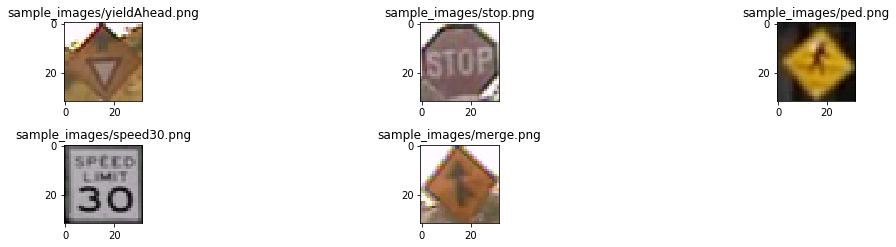

In [43]:
# Visually inspect sample images
for i, image in enumerate(images):
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(image_files[i])

plt.tight_layout()
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I obtained the above 5 images from a dataset of US traffic signs, the LISA Traffic Sign Dataset: http://cvrr.ucsd.edu/LISA/lisa-traffic-sign-dataset.html

I chose 5 traffic sign images randomly from the LISA dataset. All 5 images are color images (there are some grayscale images in the LISA dataset), and 4 of the 5 images are larger than 32x32 (one image is only 24x24). This allows maximum compatibility with my convnet, trained on 32x32 color images.

One major potential issue is that US traffic signs are different than German traffic signs, so I expect to see some errors in that regard.

#### Run predictions on sample images

In [49]:
# Load signnames.csv to map label number to sign string
label_map = {}
with open('signnames.csv', 'r') as f:
    first_line = True
    for line in f:
        # Ignore first line
        if first_line:
            first_line = False
            continue

        # Populate label_map
        label_int, label_string = line.split(',')
        label_int = int(label_int)

        label_map[label_int] = label_string

In [50]:
print(label_map)

{0: 'Speed limit (20km/h)\n', 1: 'Speed limit (30km/h)\n', 2: 'Speed limit (50km/h)\n', 3: 'Speed limit (60km/h)\n', 4: 'Speed limit (70km/h)\n', 5: 'Speed limit (80km/h)\n', 6: 'End of speed limit (80km/h)\n', 7: 'Speed limit (100km/h)\n', 8: 'Speed limit (120km/h)\n', 9: 'No passing\n', 10: 'No passing for vechiles over 3.5 metric tons\n', 11: 'Right-of-way at the next intersection\n', 12: 'Priority road\n', 13: 'Yield\n', 14: 'Stop\n', 15: 'No vechiles\n', 16: 'Vechiles over 3.5 metric tons prohibited\n', 17: 'No entry\n', 18: 'General caution\n', 19: 'Dangerous curve to the left\n', 20: 'Dangerous curve to the right\n', 21: 'Double curve\n', 22: 'Bumpy road\n', 23: 'Slippery road\n', 24: 'Road narrows on the right\n', 25: 'Road work\n', 26: 'Traffic signals\n', 27: 'Pedestrians\n', 28: 'Children crossing\n', 29: 'Bicycles crossing\n', 30: 'Beware of ice/snow\n', 31: 'Wild animals crossing\n', 32: 'End of all speed and passing limits\n', 33: 'Turn right ahead\n', 34: 'Turn left ahea

In [45]:
# Pre-process the image (don't care about label, put dummy labels)
images, _ = preprocess_data(images, np.array([0 for _ in range(images.shape[0])]))

# with tf.Graph().as_default(), tf.Session() as sess:
#     # Instantiate the CNN model
# #     x, y, keep_prob, logits, optimizer, predictions, accuracy = neural_network()

#     # Load trained weights
# saver = tf.train.Saver()
# saver.restore(sess, "./model.ckpt")
    
    # Run inference on CNN to make predictions, and remember the logits for later
lgts, preds = sess.run([logits, predictions], feed_dict={x: images, keep_prob: 1.})

final_preds = [label_map[pred] for pred in preds]

In [46]:
# Print predictions on my sample images
print('Predictions on sample images\n')
for i in range(images.shape[0]):
    print('%s --> %s' % (image_files[i], final_preds[i]))

Predictions on sample images

sample_images/yieldAhead.png --> Yield

sample_images/stop.png --> Speed limit (120km/h)

sample_images/ped.png --> Priority road

sample_images/speed30.png --> Keep left

sample_images/merge.png --> Right-of-way at the next intersection



Since I am most familiar with US traffic signs, the predicted German traffic sign labels are not immedietely obvious to me. Let's find example images of German traffic signs that fit the predicted labels above. We can sample them from the training set.

In [47]:
# Load the German Traffic Sign training set again
training_file = 'train.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

# For each of the 5 predictions,
# find an image in the test set that matches the predicted class
train_images = []
for pred in preds:
    for i, y in enumerate(y_train):
        if y == pred:
            train_images.append(X_train[i])
            break

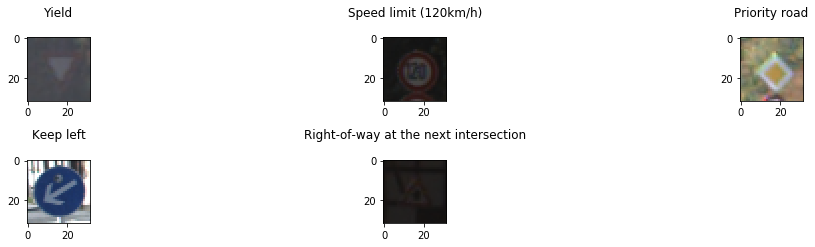

In [51]:
# Display images from test set
for i, image in enumerate(train_images):
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(final_preds[i])

plt.tight_layout()
plt.show()    

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

No, my model does _not_ perform well on the US traffic sign images I have chosen. The US 30 mph speed limit sign was recognized as a German 30 kph speed limit sign, possibly because the model recognized the digits '30'. Otherwise, I am surprised the US stop sign was not recognized, because it should be similar to a German stop sign.

There are US traffic signs in my sample images that had no similar-looking German sign (e.g. the merge sign), so I can't fault the model in that case.

#### Visualizing the softmax probabilities

Since the model did not perform well on my sample images, let's examine the top 5 predictions, in terms of the model's confidence in those predictions.

In [52]:
# Use TensorFlow's softmax and top_k functions
with tf.Graph().as_default(), tf.Session() as sess:
    logits = tf.placeholder('float', [None, NUM_CLASSES])
    softmax = tf.nn.softmax(logits)
    top_k_val, top_k_idx = tf.nn.top_k(softmax, k=5)
    
    top_k_vals, top_k_idxs = sess.run([top_k_val, top_k_idx], feed_dict={logits: lgts})

In [53]:
def display_pred_certainty(image, top_k_val, top_k_idx):
    print('Top 5 predictions for the following image (prediction: probability)')
    # Convert top k indices into strings
    top_k_pred = [label_map[idx] for idx in top_k_idx]
    
    # Show the image for reference
    plt.imshow(image)
    plt.show()
    
    for i in range(5):
        print('%s: %.2f%%' % (top_k_pred[i].replace('\n', ''), top_k_val[i] * 100))

In [54]:
# Re-read sample images
image_files  = ['sample_images/' + image_file for image_file in os.listdir('sample_images')]
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))

    images.append(image)
images = np.array(images, dtype='uint8')

# Display top 5 predictions for each sample image

Top 5 predictions for the following image (prediction: probability)


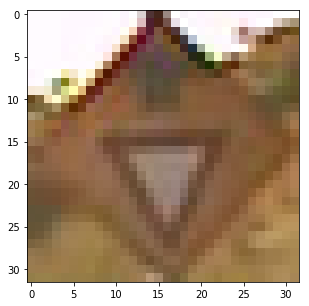

Yield: 92.78%
No passing: 5.11%
No vechiles: 1.98%
Speed limit (70km/h): 0.07%
Stop: 0.02%


In [55]:
i = 0
display_pred_certainty(images[i], top_k_vals[i], top_k_idxs[i])

My model was not very certain of its prediction, given the "merge" sign above.

The merge sign not does exist in the German Traffic Sign Dataset, but it does have some visual resemblance to the German "right-of-way at the next intersection" sign. My model was only 57.43% confident in its top prediction of "right-of-way at the next intersection" sign. It was 37.71% confident in its prediction of "vehicles over 3.5 metric tons prohibited" sign. The model was essentially torn between deciding which of the two sign labels was correct, as the next 3 predictions were all below 2% confidence.

Top 5 predictions for the following image (prediction: probability)


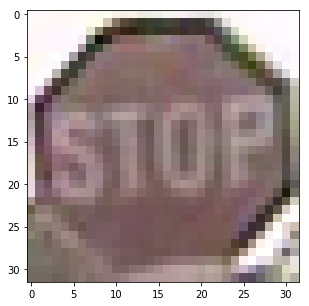

Speed limit (120km/h): 33.33%
Yield: 29.94%
Speed limit (70km/h): 25.95%
Speed limit (100km/h): 4.74%
Stop: 1.82%


In [56]:
i = 1
display_pred_certainty(images[i], top_k_vals[i], top_k_idxs[i])

My model was absolutely certain about its predction on the pedestrian sign.

The US pedestrian sign was predicted as a German priority road sign, with 100% confidence. This makes sense, because (a) there was no German pedestrian sign in the training dataset, and (b) the German priority road sign is one big yellow diamond, which is visually similar to the US pedestrian sign, without the diagram of the pedestrian. 

Top 5 predictions for the following image (prediction: probability)


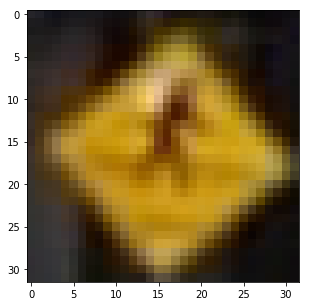

Priority road: 98.22%
End of speed limit (80km/h): 0.33%
Speed limit (80km/h): 0.28%
End of all speed and passing limits: 0.26%
End of no passing: 0.18%


In [57]:
i = 2
display_pred_certainty(images[i], top_k_vals[i], top_k_idxs[i])

My model was very certain in its prediction of the 30 mph speed limit sign.

My model had 97.37% confidence that the US 30 mph speed limit sign was a German 30 kph speed limit sign. This makes sense, as the model was likely recognizing the digits '30'.

Top 5 predictions for the following image (prediction: probability)


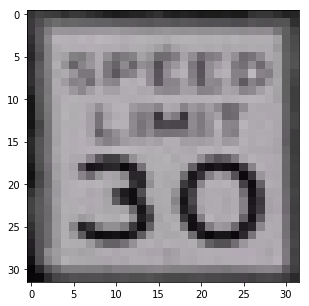

Keep left: 46.74%
Yield: 12.64%
Speed limit (70km/h): 7.64%
Dangerous curve to the left: 4.11%
End of no passing: 3.73%


In [58]:
i = 3
display_pred_certainty(images[i], top_k_vals[i], top_k_idxs[i])

My model was very uncertain about its prediction on the "yield ahead" sign.

My model predicted a German "no passing" sign with 49.67% confidence, and the second-most confident prediction was a yield sign, with 38.05% confidence. My model was mostly torn between these two predictions, although it had a slight 8.67% confidence that the image was a stop sign. This makes sense, since we didn't have a "yield ahead" sign in the training dataset (only a yield sign), and I can see why the horizontal line in the middle of the image can confuse the classifier into thinking this is a "no passing" sign.

Overall, the model performed decently when classifying this image, as the correct prediction appeared in its top-2 predictions.

Top 5 predictions for the following image (prediction: probability)


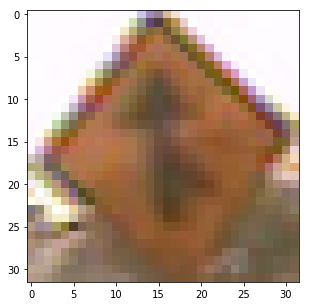

Right-of-way at the next intersection: 69.75%
Speed limit (30km/h): 8.71%
Speed limit (100km/h): 5.25%
Stop: 2.90%
No entry: 2.43%


In [59]:
i = 4
display_pred_certainty(images[i], top_k_vals[i], top_k_idxs[i])

My model was very uncertain about its prediction on the stop sign.

My model could not decide whether the image was of a speed limit sign of 100 kph (56.42% confidence) or 80 kph (38.92% confidence). Note that my model _was_ confident that this stop sign was a speed limit sign, since it had 99.24% confidence it was either a 100/80/120/30 kph speed limit sign.

For this stop sign image, the model definitely failed in its prediction. The stop sign is also present in the German dataset, but a stop sign prediction is nowhere to be found in the top-5 predictions. This is likely because stop sign images were under-represented in the training set. Since I was trying to maximize accuracy on the test set, which had a similar class imbalance to the training set, I did not balance the class distribution on the training set. If I were to create a traffic sign classifier used in production, I would definitely balance the class distributions in the training set.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

_Please refer to my comments above, for each of the 5 sample images and its top-5 predictions_

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

_The code to load and classify the newly-acquired images are available above_

## Let's try some German road sign examples

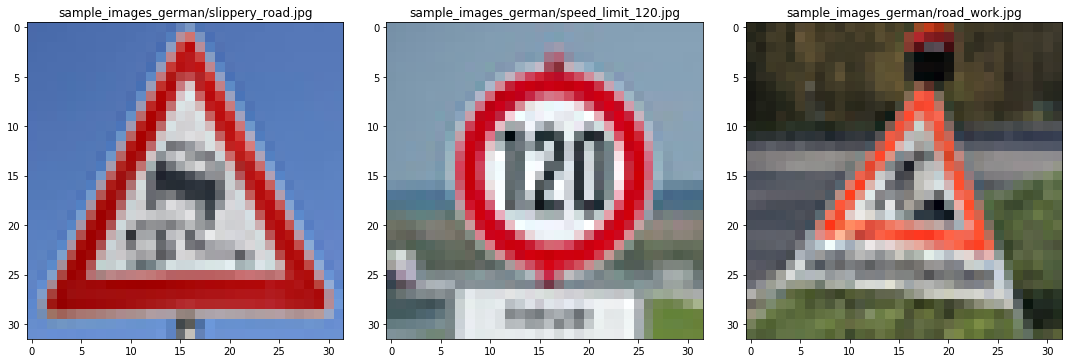

In [60]:
# Read sample image files, resize them, convert to numpy arrays w/ dtype=uint8
image_files  = ['sample_images_german/' + image_file for image_file in os.listdir('sample_images_german')]
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))

    images.append(image)
images = np.array(images, dtype='uint8')

# Visually inspect sample images
for i, image in enumerate(images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title(image_files[i])

plt.tight_layout()
plt.show()


In [64]:
# Load signnames.csv to map label number to sign string
label_map = {}
with open('signnames.csv', 'r') as f:
    first_line = True
    for line in f:
        # Ignore first line
        if first_line:
            first_line = False
            continue

        # Populate label_map
        label_int, label_string = line.split(',')
        label_int = int(label_int)

        label_map[label_int] = label_string
        
# Pre-process the image (don't care about label, put dummy labels)
images, _ = preprocess_data(images, np.array([0 for _ in range(images.shape[0])]))

# with tf.Graph().as_default(), tf.Session() as sess:
#     # Instantiate the CNN model
# #     x, y, keep_prob, logits, optimizer, predictions, accuracy = neural_network()

#     # Load trained weights
saver = tf.train.Saver()
saver.restore(sess, MODEL_SAVE_PATH)

# Run inference on CNN to make predictions, and remember the logits for later
lgts, preds = sess.run([logits, predictions], feed_dict={x: images, keep_prob: 1.})

final_preds = [label_map[pred] for pred in preds]

# Print predictions on my sample images
print('Predictions on sample images\n')
for i in range(images.shape[0]):
    print('%s --> %s' % (image_files[i], final_preds[i]))

INFO:tensorflow:Restoring parameters from ./model.ckpt


RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [ ]:
# Use TensorFlow's softmax and top_k functions
with tf.Graph().as_default(), tf.Session() as sess:
    logits = tf.placeholder('float', [None, NUM_CLASSES])
    softmax = tf.nn.softmax(logits)
    top_k_val, top_k_idx = tf.nn.top_k(softmax, k=5)
    
    top_k_vals, top_k_idxs = sess.run([top_k_val, top_k_idx], feed_dict={logits: lgts})
    
    
# Re-read sample image files, resize them, convert to numpy arrays w/ dtype=uint8
image_files  = ['sample_images_german/' + image_file for image_file in os.listdir('sample_images_german')]
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))

    images.append(image)
images = np.array(images, dtype='uint8')

def pred_certainty_str(top_k_val, top_k_idx):
    # Convert top k indices into strings
    top_k_pred = [label_map[idx] for idx in top_k_idx]
    
    pcs = ''
    for i in range(5):
        pcs += '%s: %.2f%%\n' % (top_k_pred[i].replace('\n', ''), top_k_val[i] * 100)
        
    return pcs

In [ ]:
for i, image in enumerate(images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    #plt.xlabel(pred_certainty_str(image, top_k_vals[i], top_k_idxs[i]))
    plt.xlabel(pred_certainty_str(top_k_vals[i], top_k_idxs[i]))

plt.tight_layout()
plt.show()
